<a href="https://colab.research.google.com/github/PaulisX/Codinity-uzdevums/blob/main/Val_teh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text masking

## Imports

In [45]:
!pip install stanza
!pip install -U sentence-transformers

In [46]:
!pip install line_profiler

In [47]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [48]:
!wget "https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/stopwords.txt" -O 'stopwords.txt'

--2024-06-19 08:57:18--  https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688 [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]     688  --.-KB/s    in 0s      

2024-06-19 08:57:18 (69.8 MB/s) - ‘stopwords.txt’ saved [688/688]



In [49]:
import stanza
import re
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)
from stanza.server import CoreNLPClient

# Set the CORENLP_HOME environment variable to point to the installation location
import os
os.environ["CORENLP_HOME"] = corenlp_dir

## Functions

In [50]:
def format_text(output):
  # print_help(output, 'Op')
  regexp = re.compile(r'[MSK\d*]')
  regexp2 = re.compile(r"'[A-Za-z]")
  final_output = []

  for word in range(len(output)):
    prev = output[word - 1]
    pprev = output[word - 2]
    cur = output[word]

    if not regexp.search(cur):
      if word == 0:
        cur = cur.capitalize()
      elif word > 1 and prev in ['.', '!', '?']:
        cur = cur.capitalize()

    if (cur in [".", ",", '!', '?', ':', ';'] and final_output) or regexp2.search(cur):
      final_output[-1] += cur
    elif cur == '-':
      final_output[-1] += cur
      final_output[-1] += output[word + 1]
      word += 1
    elif word == len(output) - 1 and cur not in ['.', '?', '!', '\'']:
      final_output[-1] += '.'
    else:
        final_output.append(cur)

  return ' '.join(final_output)

In [51]:
def spans_to_ranges(spans):
  msk_gr = []
  for span in spans:
    span1_start = span['span1']['start']
    span1_end = span['span1']['end']
    span2_start = span['span2']['start']
    span2_end = span['span2']['end']
    score = span['score']
    in_grp = False
    c = 0
    for gr in msk_gr:
      for rng in gr:
        if span1_start<=rng[1] and span1_end >= rng[0]:
          c+=1
        if span2_start<=rng[1] and span2_end >= rng[0]:
          c+=2
        if  c == 3 : break
      if    c == 0 :
        continue
      elif  c == 1 :
        gr.append([span2_start,span2_end,score])
        break
      elif  c == 2 :
        gr.append([span1_start,span1_end,score])
        break
      elif  c == 3 :
        break
    # print(span)
    # print(c, [span1_start,span1_end], [span2_start,span2_end])
    if c == 0: msk_gr.append([[span1_start,span1_end,score],[span2_start,span2_end,score]])

  # print('\n----------------------------------------------')
  # TODO: Check if sceanrio where ranges intersect exists, implement it
  combined = True
  while combined:
    combined=False
    for i in range(len(msk_gr)):
      for r_i in msk_gr[i]:
        for j in range(i+1,len(msk_gr)):
          for r_j in msk_gr[j]:
            if r_i[0]<=r_j[1] and r_i[1] >= r_j[0]:
              # print(r_i, r_j)
              combined = True
              for r_jj in msk_gr[j]:
                duplicate = None
                for r_ii in msk_gr[i]:
                  if r_ii[0]<=r_jj[1] and r_ii[1] >= r_jj[0]:
                    duplicate = r_ii
                    break
                if(duplicate):
                  r_ii == r_ii if r_ii[2]>r_jj[2] else r_jj
                else:
                  msk_gr[i].append(r_jj)
              msk_gr.pop(j)
            if(combined):break
          if(combined):break
        if(combined):break
      if(combined):break

  # print('----------------------------------------------')
  return msk_gr

In [52]:
def get_similar_spans(spans, cos_threshold, model):
  embedings =  model.encode([s["text"] for s in spans])
  similar_spans = []
  for i in range(len(spans)-1):
    emb = embedings[i]
    for j in range(i+1,len(spans)):
      if spans[j]['start'] <= spans[i]['end']:
        continue
      emb_chk = embedings[j]
      cos_score = cosine_similarity([emb], [emb_chk])
      if(cos_score>=cos_threshold):
        score = 1*cos_score + 0.15*(1-1/(spans[i]['end']+1-spans[i]['start']+spans[j]['end']+1-spans[j]['start'])) # cos_score +  length of text

        similar_spans.append({
            'score': score, 'cos:':cos_score
            ,'span1':spans[i]
            ,'span2':spans[j]})
  similar_spans = sorted(similar_spans, key=lambda d: d['score'], reverse=True)
  return similar_spans

In [53]:
def get_spans(words, stopwords):
  spans=[]
  regexp = re.compile(r'[MSK\d*]')
  range(len(words))
  for i in range(len(words)):
    for j in range(i+1, len(words)+1):
      c = False
      for w in words[i:j]:
        if w in stopwords:
          c = True
          break
      if c: continue

      s = ' '.join(words[i:j])
      # s=s.replace(' ,','')
      if(regexp.search(s) or s ==','):
        continue
      spans.append({"text":s, "start":i, "end": j-1})
  return spans

In [54]:
def coref_mask_and_tokenize(text, core_nlp_client):
  msk_id=0
  document = core_nlp_client.annotate(text)
  corefs = document.corefChain
  # print(corefs)
  resolved = []
  chain_mask = {}
  for chain in corefs:
    if len(chain.mention) == 1:
      continue
    msk_id+=1
    chain_mask[chain.chainID]='[MSK'+str(msk_id)+']'

  words = []
  words_lemmatized = []
  for sentence in document.sentence:
    for token in sentence.token:
        corefClustId = token.corefClusterID
        chain = None
        for c in corefs:
          if c.chainID == corefClustId:
            chain = c
            break

        if chain is None or len(chain.mention) == 1:
          word = token.word.lower()
          word_l = token.lemma
        else:
          word = chain_mask.get(chain.chainID)
          word_l = word
        words.append(word)
        words_lemmatized.append(word_l)
  return words, words_lemmatized, msk_id


In [55]:
def get_stopwords():
    # Open the file and read the stopwords
    with open("stopwords.txt", "r") as text_file:
        stopwords = text_file.read().splitlines()

    return stopwords

In [56]:
def remove_quotes(text):
    result = []
    for word in text:
        new_word = word.replace('"', '').replace('”', '').replace('“', '')
        result.append(new_word)
    return result

In [57]:
def print_help(obj, name='Obj'):
  print(name, '=', end=" ")
  for item in obj:
    print(item, end =" "),
  print()

In [58]:
def mask_word_ranges(words, mask_ranges, msk_index):
  d = dict(enumerate(map(str, words)))
  for msk in mask_ranges:
    # print(msk)
    msk_index+=1
    msk_txt = '[MSK'+str(msk_index)+']'
    for r in msk:
      d[r[0]]= msk_txt
      for i in range(r[0]+1,r[1]+1):
        if(i in d):
          d.pop(i)
  arr = [v for k, v in d.items()]
  return arr

In [59]:
def mask_text_file(text_arr, core_nlp_client, out_file_name, write_mode, model):
  stopwords = get_stopwords()

  text_arr = remove_quotes(text_arr)

  result = []
  write_queue=[]
  total = len(text_arr)
  i = 0

  for text in text_arr:
    i+=1
    words, words_lemmatized, mask_count = coref_mask_and_tokenize(text, core_nlp_client)
    # print(words)
    spans = get_spans(words_lemmatized, stopwords)
    print(f'\r{round((i / total) * 100, 2)}% / 100% (', i , ')', end='', flush=True)

    if not spans:
      result=text
      write_queue.append(result+'\n')
      print('\nNo valid spans')
      continue

    similar_spans = get_similar_spans(spans, .91, model)
    mask_ranges = spans_to_ranges(similar_spans)

    maksed_words = mask_word_ranges(words, mask_ranges, mask_count)
    # maksed_words = mask_word_ranges(words_lemmatized, mask_ranges, mask_count)

    result = format_text(maksed_words)
    write_queue.append(result + '\n')

  write_queue_df = pd.DataFrame(write_queue)
  write_queue_df.to_csv(out_file_name, index=False, quoting=1)
  print('\nFinished!')


In [60]:
def mask_text(text_arr, core_nlp_client, model):
  stopwords = get_stopwords()
  text_arr = remove_quotes(text_arr)
  result = []
  total = len(text_arr)

  for text in text_arr:
    words, words_lemmatized, mask_count = coref_mask_and_tokenize(text, core_nlp_client)
    spans = get_spans(words_lemmatized, stopwords)
    if not spans:
      result.append(text)
      continue

    similar_spans = get_similar_spans(spans, .90, model)
    mask_ranges = spans_to_ranges(similar_spans)

    maksed_words = mask_word_ranges(words, mask_ranges, mask_count)
    # maksed_words = mask_word_ranges(words_lemmatized, mask_ranges, mask_count)

    result.append(format_text(maksed_words))

  return  result

# NLI

In [ ]:
!wget https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/mapping.json -O 'mapping.json'

--2024-06-19 08:33:23--  https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/mapping.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [text/plain]
Saving to: ‘mapping.json’

mapping.json        100%[===================>]   1.49K  --.-KB/s    in 0s      

2024-06-19 08:33:23 (40.2 MB/s) - ‘mapping.json’ saved [1521/1521]



In [ ]:
!pip install transformers pandas scikit-learn

In [ ]:
import pandas as pd
import json
import re
from transformers import pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import os

In [ ]:
def get_labels(file_name):
  with open(file_name, 'r') as file:
      candidate_labels = json.load(file)

  # first_items = []
  second_items = []

  for key, value in candidate_labels.items():
      # first_items.append(key)
      second_items.append(value)

  # print(second_items)
  return second_items

In [ ]:
def map_mask_to_understandable(arr):
  with open('mapping.json', 'r') as file:
      labels = json.load(file)

  first_items = list(labels.keys())
  second_items = list(labels.values())

  mapped_arr = []
  for a in arr:
      if a in second_items:
          index = second_items.index(a)
          mapped_arr.append(first_items[index])
      else:
          mapped_arr.append(a)

  return mapped_arr

In [ ]:
def classify_sequence(args,clasifier):
    line, candidate_labels = args
    result = clasifier(line, candidate_labels)
    highest_score_index = result['scores'].index(max(result['scores']))
    highest_score_label = result['labels'][highest_score_index]
    highest_score = max(result['scores'])

    return result['labels'][0]
    # return highest_score_label, highest_score
    # print(line, highest_score_label, '\n', highest_score, '\n', result['scores'])
    # print('<--------------------------------->')

In [42]:
def do_classification(input_text, mapping, total, model, save, isFile):
  classifier = pipeline("zero-shot-classification", model)
  candidate_labels = get_labels(mapping)

  if isFile == 'y':
    df = pd.read_csv(input_text)
    # df = df.iloc[0:total] # first total lines
    # df = df.sample(n=total, random_state=1) # random total lines
    true_labels = df['updated_label'].tolist()
    true_labels = map_mask_to_understandable(true_labels)
    df = df['source_article']
    # print('T = ', '\n', true_labels)
    # print('Tlen = ', len(true_labels))
    # print('C = ', '\n', candidate_labels)

    cnt = 1
    predictions = []

    for line in df:
      prediction = classify_sequence([line, candidate_labels],classifier)
      predictions.append(prediction)
      # print(cnt, '/', total)
      print(f'\r{round((cnt / total) * 100, 2)}% / 100% (', cnt , ')', end='', flush=True)
      cnt += 1

    predictions = map_mask_to_understandable(predictions)
    # print('P = ', '\n', predictions)
    # print('Plen = ', len(predictions))
    all_labels = map_mask_to_understandable(candidate_labels)

    # unique_labels = list(set(true_labels + predictions))
    report = classification_report(true_labels, predictions, labels = all_labels)
    print('\n', report)

    matrix = confusion_matrix(true_labels, predictions, labels=all_labels)
    sb.heatmap(matrix, xticklabels=all_labels, yticklabels=all_labels, annot=True, fmt="d")
    plt.xticks(rotation=90)
    os.makedirs('results', exist_ok=True)
    if save == 'y':
      plt.savefig('results/heatmap.png', bbox_inches='tight')
    plt.show()

    result_df = pd.DataFrame({
        'actual': true_labels,
        'prediction': predictions
    })
    if save == 'y':
      result_df.to_csv('results/act_pred.csv')
      report_df = pd.DataFrame([report])
      report_df.to_csv('results/report.csv', index=False)
      !zip -r results.zip 'results'
  else:
      prediction = classify_sequence([input_text, candidate_labels],classifier)
      print(map_mask_to_understandable([prediction])[0],':',prediction)

# DEMO

In [64]:
# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(
    annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner', 'coref'],
    memory='4G',
    endpoint='http://localhost:9001',
    be_quiet=True)
print(client)
client.start()

INFO:stanza:Writing properties to tmp file: corenlp_server-e071e6047e3e4e1e.props
INFO:stanza:Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e071e6047e3e4e1e.props -annotators tokenize,ssplit,pos,lemma,ner,coref -preload -outputFormat serialized


In [67]:
# # Load the pre-trained model
# with open("nb_classifier.pickle", "rb") as dmp:
#     nb = pickle.load(dmp)
#     print("[I] NB classifier loaded from a file")


cos_sim_model = SentenceTransformer('bert-base-nli-mean-tokens')
mapping = 'mapping.json'
# model = 'cross-encoder/nli-distilroberta-base'
model = 'facebook/bart-large-mnli'
# model = "google/electra-large-discriminator"
save = 'y'
isFile = 'n'
total = 1
## False casulaity
# + If Joe eats greasy food, he will feel sick. Given now that Joe feels sick, therefore, Joe must have had greasy food.
# + Jack is a good athlete. Jack comes from Canada. Therefore, all Canadians are good athletes.
## Faulty General-ization
# + Every severe recession follows a Republican Presidency; therefore Republicans are the cause of recessions.
# - Sometimes flu vaccines don’t work; therefore vaccines are useless.
## Fallacy of relevance
# - Why are you worried about poverty? Look how many children we abort every day.
## Circular reasoning
# + Only an untrustworthy person would run for president. The fact that politicians are untrustworthy is proof of that
# - Only an untrustworthy person would run for president. The fact that politicians are untrustworthy is proof of that.
while True:
    text = input("\nEnter a text to classify: ")
    if len(text) == 0: break

    # Extract text features for classification
    masked_array =  mask_text([text], client, cos_sim_model)
    print("\nMasked text:", masked_array[0], "\n")
    input_text = masked_array[0]


    do_classification(input_text, mapping, total, model, save, isFile)



Enter a text to classify: If Joe eats greasy food, he will feel sick. Given now that Joe feels sick, therefore, Joe must have had greasy food.


INFO:stanza:Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-e071e6047e3e4e1e.props -annotators tokenize,ssplit,pos,lemma,ner,coref -preload -outputFormat serialized



Masked text: If [MSK1] eats [MSK2], [MSK1] will [MSK3]. Given now that [MSK1] [MSK3], therefore, [MSK1] must have had [MSK2]. 

false causality : [MSK1] occurred, then [MSK2] occurred. Therefore, [MSK1] caused [MSK2].


KeyboardInterrupt: Interrupted by user

In [ ]:
client.stop()

# Testing

- Pieliku klat profileri (visu laiku patere coref_mask_and_tokenize() un get_similar_spans());
- Uzliku skaistaku progresa printu;
- Pieliku get_stopwords klat paris stopwordus;
- Ieliku savu format_text, jo bija problemas ar lielajiem burtiem, punktiem, pēdiņām utt.
- Pieliku metodi remove_quotes.
- Pamainiju mask_text faila izveidi.
- output.csv fails ar 1108 rindinam:
https://github.com/HaraldsU/VTP_LPD/blob/main/output.csv


In [ ]:
!wget "https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/input_full.csv" -O 'input_full.csv'

--2024-06-19 08:33:44--  https://raw.githubusercontent.com/HaraldsU/VTP_LPD/main/Data/input_full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 865823 (846K) [text/plain]
Saving to: ‘input_full.csv’

input_full.csv      100%[===================>] 845.53K  3.97MB/s    in 0.2s    

2024-06-19 08:33:45 (3.97 MB/s) - ‘input_full.csv’ saved [865823/865823]



In [ ]:
def remove_excessive_lines(df, max_words=100):
    # Filter rows where the word count in 'source_article' is less than or equal to max_words
    df_filtered = df[df['source_article'].apply(lambda x: len(x.split()) <= max_words)]
    return df_filtered

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(
    annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner', 'coref'],
    memory='4G',
    endpoint='http://localhost:9001',
    be_quiet=True)
print(client)
client.start()


# df = pd.read_csv('input.csv')
# df = df[0:100]
# selected_rows = df.iloc[0:99] # First 99 rows

df = pd.read_csv('input_full.csv')
df_reduced = remove_excessive_lines(df,100)
df_reduced.to_csv('input_reduced.csv', index=False)

rows = df_reduced['source_article']

# rows = text
print('Row count = ', len(rows))

# %lprun -f mask_text_file mask_text_file(rows, client, "output_full.csv", 'w', model)
mask_text_file(rows, client, "output_reduced.csv", 'w', model)
client.stop()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
INFO:stanza:Writing properties to tmp file: corenlp_server-81d9cc96388f46f8.props
INFO:stanza:Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-81d9cc96388f46f8.props -annotators tokenize,ssplit,pos,lemma,ner,coref -preload -outputFormat serialized


Row count =  2210


KeyboardInterrupt: 

In [ ]:
output = pd.read_csv('output_reduced.csv')
input = pd.read_csv('input_reduced.csv')

input['source_article'] = output
input.to_csv('output_reduced.csv', index=False)


In [ ]:
from transformers import AutoTokenizer, AutoModelForPreTraining, AutoModelForCausalLM, AutoModelForSequenceClassification

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


100.0% / 100% ( 2210 )
                         precision    recall  f1-score   support

            ad hominem       0.11      0.01      0.01       264
            ad populum       0.78      0.10      0.18       207
     appeal to emotion       0.00      0.00      0.00       156
    circular reasoning       0.07      0.18      0.10       159
          equivocation       0.02      0.15      0.04        47
fallacy of credibility       0.41      0.12      0.18       126
  fallacy of extension       0.06      0.38      0.10       115
      fallacy of logic       0.16      0.26      0.20       144
  fallacy of relevance       0.04      0.01      0.02       147
       false causality       0.37      0.21      0.27       189
         false dilemma       0.00      0.00      0.00       126
 faulty generalization       0.30      0.07      0.11       399
           intentional       0.07      0.10      0.08       131

              accuracy                           0.11      2210
             m

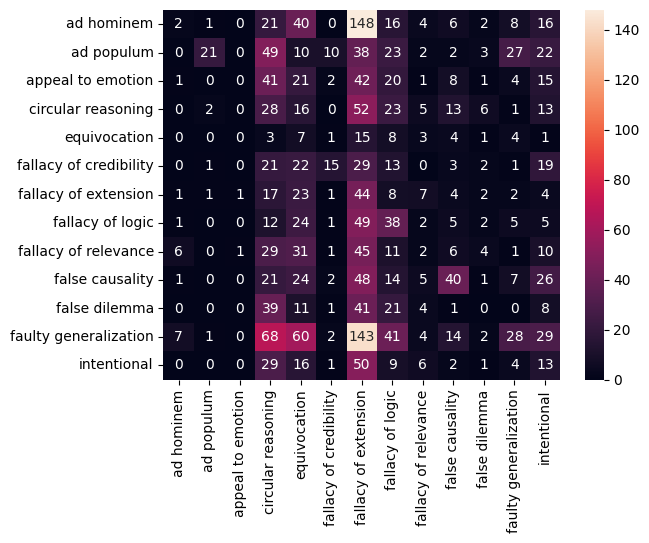

  adding: results/ (stored 0%)
  adding: results/act_pred.csv (deflated 90%)
  adding: results/report.csv (deflated 68%)
  adding: results/heatmap.png (deflated 9%)


In [63]:
  mapping = 'mapping.json'
  input_text = 'output_reduced.csv'
  # input_text = 'Hah aha I am you are.'
  # model = "sileod/deberta-v3-small-tasksource-nli")
  # model = "cross-encoder/nli-distilroberta-base" # Even faster
  # model = "valhalla/distilbart-mnli-12-9"
  # model = "sileod/deberta-v3-small-tasksource-nli"
  # model = 'facebook/bart-large-mnli'
  # model = 'mjwong/e5-large-mnli'
  model = 'typeform/distilbert-base-uncased-mnli'

  save = 'y'
  isFile = 'y'
  total = 2210

  do_classification(input_text, mapping, total, model, save, isFile)